# emtsv használata Pythonban, segédnotebook

## Csomagok importálása

In [1]:
import requests
import pandas as pd  # for dataframes
from io import StringIO  # for dataframes

## Pythonban lévő szöveg átadása az emtsvnek

In [2]:
text = 'Ki korán kel, aranyat lel.'
r = requests.post('http://127.0.0.1:5000/tok/morph/pos', data={'text': text})
ana = pd.read_table(StringIO(r.text))
ana[['form', 'xpostag']]

,form,xpostag
0,Ki,[/Prev]
1,korán,[/Adv]
2,kel,[/V][Prs.NDef.3Sg]
3,",",[Punct]
4,aranyat,[/N][Acc]
5,lel,[/V][Prs.NDef.3Sg]
6,.,[Punct]


## UTF8-as fájl használata

Megjegyzés: nagyon figyeljünk, hogy a kimeneti formátumnál specifikáljuk az UTF8-as enkódolást.

In [3]:
infile_path = 'resources/Ablonczy_utf8.txt'
outfile_path = 'resources/ablonczy_pos.tsv'
# always specify UTF8 if input file is UTF8!
with open(infile_path, 'r', encoding='UTF8') as infile, open(outfile_path, 'w', encoding='UTF8') as outfile:
    r = requests.post('http://127.0.0.1:5000/tok/morph/pos', files={'file': infile})
    outfile.write(r.text)

## Nem UTF8-as fájl használata

Ha a Windows hozta létre saját maga a fájlt (például internetről beillesztettünk a Jegyzettömbbe), akkor előfordulhat, hogy alapértelmezett enkódolású fájlunk van. Ekkor üresen hagyhatjuk az `encoding` mezőt, és a Python alapértelmezett enkódolásúként olvassa be.

A Python a bejövő fájlt memóriában átkonvertálja UTF8-ra, így a beolvasás után legközelebb már csak a kiírásnál kell figyelnünk az enkódolásra.

In [ ]:
infile_path = 'resources/Ablonczy_notutf8.txt'
outfile_path = 'resources/ablonczy_pos.tsv'
# input file is NOT utf8, thus we are using the default encoding
with open(infile_path, 'r') as infile, open(outfile_path, 'w', encoding='UTF8') as outfile:
    r = requests.post('http://127.0.0.1:5000/tok/morph/pos', files={'file': infile})
    outfile.write(r.text)

# Gyakori példák, problémák

Importálunk ábrák készítéséhez csomagokat.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# we set the style to have nicer default plots
sns.set_style('darkgrid')

## Hibás fájl kezelése

A bemeneti fájl tartalmaz(hat) extra tabokat, ami hibát fog okozni, hiszen egy-egy oszlop ilyenkor nem 4 széles (azaz 3 tabbal elszeparált mező), hanem szélesebb. Ilyenkor hibára fogunk futni.

In [ ]:
# produces error due to bad file
data = pd.read_csv('resources/ablonczy_pos.tsv', delimiter='\t', encoding='UTF8')

Megadhatjuk a pandasnak, hogy ugorja át a hibás sorokat, és hogy ne is figyelmeztessen miattuk.

In [16]:
data = pd.read_csv('resources/ablonczy_pos.tsv', delimiter='\t', encoding='UTF8', error_bad_lines=False, warn_bad_lines=False)

## Nagy fájl beolvasása pandas használata nélkül

Itt most éppen a tokeneket tesszük egy Python listába, de a határ a csillagos ég.

In [6]:
infile_path = 'resources/ablonczy_pos.tsv'
tokens = []

with open(infile_path, 'r', encoding='UTF8') as infile:
    for line in infile:
        splitted_line = line.strip().split('\t')
        # we KNOW that there are 5 columns since we created the file
        if len(splitted_line) != 5:
            # we skip to the next line if there are no 5 columns in this line
            continue
        else:
            form, wsafter, anas, lemma, xpostag = splitted_line
            tokens.append(form)
        

## Gyakorisági táblák készítése pandassal

A matplotlib a legsűrűbben használt csomag vizualizálásra, tanulni kell a használatát, de gyors elemzésre a pandason keresztül is elérhető és _barátságos_ a szintaxisa.

In [7]:
pos_frequencies = data['xpostag'].value_counts()
pos_frequencies

[Punct]                                    28646
[/N][Nom]                                  23807
[/Adj][Nom]                                18811
[/Det|Art.Def]                             17300
[/Cnj]                                      9401
                                           ...  
[/Adj|Pro][Pl][AnP][Nom]                       1
[/Supl][/Adj][_Comp/Adj][Poss.3Sg][Nom]        1
[/N|Pro][Supe]                                 1
[/V][_Caus/V][Inf.3Sg]                         1
[/V][Sbjv.Def.2Sg][Punct]                      1
Name: xpostag, Length: 940, dtype: int64

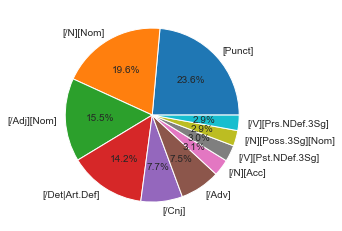

In [8]:
pos_frequencies.head(10).plot.pie(autopct="%.1f%%")  # we choose the first 10
plt.ylabel('')  # not necessary
plt.show()  # not necessary 

In [9]:
lemmas_freq = data['lemma'].value_counts()
lemmas_freq

a                   13246
,                   13067
.                    8372
az                   5142
és                   3599
                    ...  
hószínû                 1
Csáky                   1
Idõtlenség              1
beadványozás            1
dokumentum-próza        1
Name: lemma, Length: 21930, dtype: int64

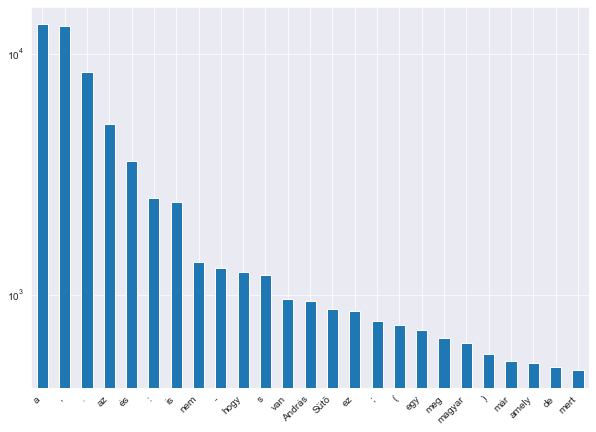

In [10]:
plt.figure(figsize=(10, 7))
lemmas_freq.head(25).plot.bar()
plt.yscale('log')
plt.xticks(rotation=45, horizontalalignment="right")
plt.show()

<AxesSubplot:xlabel='lemma'>

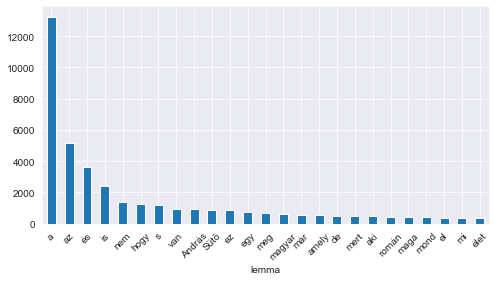

In [11]:
no_punct_freq = data.query('xpostag != "[Punct]"').value_counts('lemma')
plt.figure(figsize=(8,4))
no_punct_freq.head(25).plot.bar(rot=45)

## Több kimenet összefűzése
Most éppen mondatokat adunk át, de fájlokkal pontosan ugyanígy működik. Szétvágjuk az első enternél fejlécre és tartalomra a kimenetet, az első fejlécet megtartjuk, a többit meg eldobjuk. A kimenetek végén dupla enter keletkezik, azt levágjuk.

In [12]:
sentences = ['Ki korán kel, aranyat lel.', 'Száz sasszem meg száz sasszem az sok száz sasszem.', 'Jobb egy lúdnyak tíz tyúknyaknál.']
output = ''
for sentence in sentences:
    r = requests.post('http://127.0.0.1:5000/tok/morph/pos', data={'text': sentence})
    header, content = r.text.split('\n', 1)
    if output == '':
        output += header + '\n'
    output += content

A feldolgozást tovább lehet láncolni. Ha egy már POS-taggelt szöveget szeretnénk dependenciaelemezni, akkor azt egyszerűen lehet.

In [13]:
r = requests.post('http://127.0.0.1:5000/conv-morph/dep', files={'file': output}) 

In [14]:
table = pd.read_table(StringIO(r.text))

In [15]:
table[['form', 'xpostag', 'id', 'deprel', 'head']]

,form,xpostag,id,deprel,head
0,Ki,[/Prev],1,TLOCY,3
1,korán,[/Adv],2,TLOCY,3
2,kel,[/V][Prs.NDef.3Sg],3,ROOT,0
3,",",[Punct],4,PUNCT,3
4,aranyat,[/N][Acc],5,OBJ,6
5,lel,[/V][Prs.NDef.3Sg],6,COORD,3
6,.,[Punct],7,PUNCT,0
7,Száz,[/Num][Nom],1,ATT,2
8,sasszem,[/N][Nom],2,ATT,9
9,meg,[/Cnj],3,CONJ,2
